<a href="https://colab.research.google.com/github/snghynn/stat_programming/blob/main/stat_programming_4_Logistic_Regression_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# 1. Logistic regression with Pytorch
## 1.1 Preparation of data

Here, we will build binary logistic regression models with Python that will predict whether a breast cancer tumor is malignant or benign (malignant or benign will be our response variable). We will use the Breast Cancer Wisconsin (Diagnostic) Data Set available from sklearn.datasets.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset

We can import this data as follows:

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer1 = load_breast_cancer()

In [ ]:
print("Predictors: ", cancer1.feature_names)

Predictors:  ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [ ]:
print("\nResponse: ", cancer1.target_names)  # target name이 양성/악성으로 구성됨


Response:  ['malignant' 'benign']


Here we can see that there are 30 predictors available in our dataset that can be used in our logistic regression models.

Purely for convenience, we convert this sklearn.utils.Bunch object to a pandas.DataFrame as pandas DataFrames are a very commonly used data structure. We then use the shape property to see it has 569 rows and 30 columns.

In [ ]:
import pandas as pd

cancer = pd.DataFrame(cancer1.data, columns=cancer1.feature_names)
cancer.columns = cancer.columns.str.replace(' ','_')
cancer.shape # 데이터가 569행, 30개의 특성으로 이루어짐

(569, 30)

In [ ]:
cancer1.target[:50] # 1 means malignant.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1])

In [ ]:
X = torch.tensor(cancer.values, dtype=torch.float32)
X_mean = torch.mean(X, axis=0)
X_std = torch.std(X, axis=0)
XX = (X-X_mean)/X_std
n=XX.shape[0]
Y = torch.tensor(cancer1.target, dtype=torch.float32).reshape([n,1])

dataset = TensorDataset(XX,Y)
trainloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [ ]:
torch.manual_seed(2023)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = DataLoader(dataset=train_dataset, batch_size=train_size, shuffle=True)
testloader = DataLoader(dataset=test_dataset, batch_size=test_size, shuffle=True)

Exercise 1:

Using the data above, we want to build the logistic regression model to predict whether the tumor is malignant or benign. Answer the following questions.

1. Train the model.


In [ ]:
# 로지스틱 회귀 모델 정의
def logistic_regression(input_size):
    model = torch.nn.Sequential(
        torch.nn.Linear(input_size, 1),
        torch.nn.Sigmoid()  # 이진 분류를 위해 시그모이드 활성화 함수 적용
    )
    return model


# 비용 함수 정의
def criterion(phat, y):
    neg_loglik = - torch.mean(y * torch.log(phat) + (1-y)* torch.log(1-phat) )
    return neg_loglik

model = logistic_regression(X.shape[1])  # 데이터셋의 입력 크기를 기반으로 로지스틱 회귀 모델 생성
criterion = torch.nn.BCELoss()   # 이진 교차 엔트로피 손실 정의
my_optim = torch.optim.SGD(model.parameters(), lr=0.01)  # SGD 사용한 optimizer 정의

In [ ]:
# model 훈련
epochs = 1000
history = []

for _ in range(epochs):
    loss_sum = 0
    for xx, yy in trainloader:
        yhat = model(xx)
        loss = criterion(yhat, yy)
        loss_sum += loss.item() * len(yy)
        loss.backward()
        my_optim.step()
        my_optim.zero_grad()
    history.append(loss_sum / len(dataset))

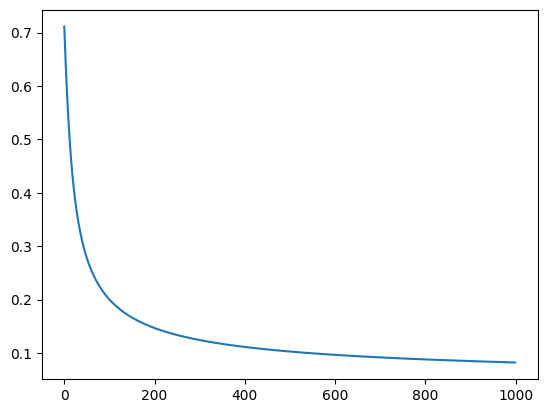

In [ ]:
plt.plot(history)


2. You want to predict the probability of malignant for the first person `X[0, ]`. Calculate the probability of malignant for the first person.


In [ ]:
X0_stand = (X - X_mean)/ X_std  # 정규화된 값을 X0_stand에 넣기

In [ ]:
model.state_dict() # model 학습에 weight가 잘 들어가있나 확인

OrderedDict([('0.weight',
              tensor([[-0.3057, -0.3408, -0.2994, -0.3061, -0.2438, -0.2822, -0.2862, -0.3088,
                        0.0149,  0.2368, -0.4926, -0.0425, -0.2717, -0.2543, -0.0245,  0.0730,
                        0.1567, -0.0208,  0.1096,  0.1543, -0.5784, -0.3465, -0.5340, -0.3178,
                       -0.2001, -0.2034, -0.2029, -0.5197, -0.3944, -0.1966]])),
             ('0.bias', tensor([0.2516]))])

In [ ]:
model(X0_stand)[0]  # X0_stand 중에서 첫번째 값들을 빼오기: 첫번째 사람에 대한 예측확률 알기

tensor([1.9657e-05], grad_fn=<SelectBackward0>)


  
3. Consider the first person whose mean_radius has shurunked from `17.990000` to `5.00000`. What is the probability of malignant.



In [ ]:
X[0,:]

tensor([1.7990e+01, 1.0380e+01, 1.2280e+02, 1.0010e+03, 1.1840e-01, 2.7760e-01,
        3.0010e-01, 1.4710e-01, 2.4190e-01, 7.8710e-02, 1.0950e+00, 9.0530e-01,
        8.5890e+00, 1.5340e+02, 6.3990e-03, 4.9040e-02, 5.3730e-02, 1.5870e-02,
        3.0030e-02, 6.1930e-03, 2.5380e+01, 1.7330e+01, 1.8460e+02, 2.0190e+03,
        1.6220e-01, 6.6560e-01, 7.1190e-01, 2.6540e-01, 4.6010e-01, 1.1890e-01])

In [ ]:
# 첫 번째 사람에 대한 조정된 mean_radius를 가진 새로운 feature tensor 생성
adjusted_mean_radius = torch.tensor(5.0, dtype=torch.float32).reshape(1, 1)

# 첫 번째 사람에 대한 원래의 feature 데이터 가져오고 mean_radius를 조정된 값으로 대체
X_adjusted = X[0, :].clone()
X_adjusted[0] = adjusted_mean_radius

X_adjusted

tensor([5.0000e+00, 1.0380e+01, 1.2280e+02, 1.0010e+03, 1.1840e-01, 2.7760e-01,
        3.0010e-01, 1.4710e-01, 2.4190e-01, 7.8710e-02, 1.0950e+00, 9.0530e-01,
        8.5890e+00, 1.5340e+02, 6.3990e-03, 4.9040e-02, 5.3730e-02, 1.5870e-02,
        3.0030e-02, 6.1930e-03, 2.5380e+01, 1.7330e+01, 1.8460e+02, 2.0190e+03,
        1.6220e-01, 6.6560e-01, 7.1190e-01, 2.6540e-01, 4.6010e-01, 1.1890e-01])

In [ ]:
# 조정된 feature 데이터를 PyTorch tensor로 변환
X0_new = (X_adjusted-X_mean)/X_std
# 모델을 사용하여 예측 수행
model(X0_new)

tensor([6.0666e-05], grad_fn=<SigmoidBackward0>)

4. Calculate the Test accuracy.

In [ ]:
# 변수 초기화
correct_predictions = 0
total_examples = 0

model.eval() # 모델을 평가 모드로 설정

# 테스트 데이터셋을 반복
with torch.no_grad():
    for xx, yy in test_dataset:
        phat = model(xx) # 모델을 사용하여 예측 수행

        # 예측을 이진 (0 또는 1)으로 변환
        predicted_class = (phat >= 0.5).float()

        # 예측 업데이트
        correct_predictions += (predicted_class == yy).sum().item()
        total_examples += len(yy)

# test accuracy 계산
test_accuracy = correct_predictions / total_examples
print(test_accuracy)

0.9883040935672515


# 2. Poisson regression with Pytorch
## 2.1 Preparation of data

In [ ]:
df = pd.read_csv(r"competition_awards_data.csv",  sep = ',', header= 0 )
df.head()

,Awards,Math Score
0,0,43
1,0,38
2,0,41
3,0,33
4,0,39


In [ ]:
x = torch.tensor(df['Math Score'].values, dtype=torch.float32)
n = len(x)

x_mean = torch.mean(x)
x_std = torch.std(x)
xx = (x-x_mean)/x_std

y = df['Awards'].values

ones = torch.ones([n])
X = torch.stack([ones, xx], axis=1)
Y = torch.tensor(y.reshape([n,1]), dtype=torch.float32)

dataset2 = TensorDataset(X,Y)
trainloader2 = DataLoader(dataset=dataset2, batch_size=32, shuffle=True)

In [ ]:
torch.manual_seed(2023)
train_size = int(0.7 * len(dataset2)) # 70%는 train data
test_size = len(dataset2) - train_size # 30%는 test data
train_dataset2, test_dataset2 = torch.utils.data.random_split(dataset2, [train_size, test_size])

trainloader2 = DataLoader(dataset=train_dataset2, batch_size=32, shuffle=True)
testloader2 = DataLoader(dataset=test_dataset2, batch_size=test_size, shuffle=True)

Exercise 2:

Using the data above, we want to build the poisson regression model to predict the number of awards.

Model 1
```
Awards ~ exp(beta0 + beta1 * MathScore)
```





Answer the following questions.

1. Train the model.

In [ ]:
# model 생성
def model2(xx):
    temp = torch.exp(xx @ beta2)
    return temp

# loss를 위한 criterion 생성
def criterion(yhat, yy):
    loglik = -torch.mean(-yhat + yy*torch.log(yhat)-torch.lgamma(yy+1))
    return loglik

In [ ]:
# 학습을 위한 beta 초기값 부여
beta2 = torch.tensor(torch.randn([2,1])*0.01, requires_grad = True)

# 학습 parameter 업데이트를 위한 optimizer 이용
my_optimizer = torch.optim.SGD([beta2], lr=0.01)

<ipython-input-165-3363b48de874>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta2 = torch.tensor(torch.randn([2,1])*0.01, requires_grad = True)


In [ ]:
n = len(X)
epochs = 1000
history = []

for _ in range(epochs):
    Loss = 0

    for xx, yy in trainloader2:
        yhat = model2(xx)
        loss = criterion(yhat, yy)
        Loss = Loss + loss * len(yy)
        loss.backward()

        my_optimizer.step()
        my_optimizer.zero_grad()

    history.append(Loss.item()/n)

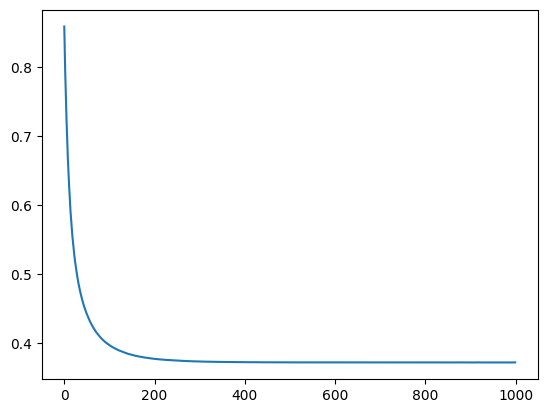

In [ ]:
plt.plot(history)

2. You want to predict the number of awards for a person having `Math Score = 47`. Calculated the predicted number of awards for this person.



In [ ]:
# 수학 점수가 47일 때의 표준화된 점수 계산
math_score = 47
std_math = (math_score - df['Math Score'].mean())/ df['Math Score'].std()
# 모델을 사용하여 예측 수행
model2(torch.tensor([1,std_math]).to(torch.float32))

tensor([0.1562], grad_fn=<ExpBackward0>)

You are also considering the following model

Model 2
```
Awards ~ exp(beta0 + beta1 * MathScore + beta2 * MathScore**2)
```



3. Calculate the Test MSE for each model. Which model is better in terms of Test MSE?

In [ ]:
X_new = torch.concat([X,(X[:,1]**2).reshape(-1,1)], axis = 1)
Y = torch.tensor(y.reshape([n,1]), dtype=torch.float32)
dataset3 = TensorDataset(X_new,Y)

# 데이터 split
torch.manual_seed(2023)
train_size = int(0.7 * len(dataset3))
test_size = len(dataset3) - train_size
train_dataset3, test_dataset3 = torch.utils.data.random_split(dataset3, [train_size, test_size])

trainloader3 = DataLoader(dataset=train_dataset3, batch_size=32, shuffle=True)
testloader3 = DataLoader(dataset=test_dataset3, batch_size=test_size, shuffle=True)

In [ ]:
# model 생성
def model3(xx):
    temp = torch.exp(xx @ beta3)
    return temp

# loss를 위한 criterion 생성
def criterion(yhat, yy):
    loglik = -torch.mean(-yhat + yy*torch.log(yhat)-torch.lgamma(yy+1))
    return loglik
# 학습을 위한 beta 초기값 부여
beta3 = torch.tensor(torch.randn([3,1])*0.01, requires_grad = True)

# 학습 parameter 업데이트를 위한 optimizer 이용
my_optimizer = torch.optim.SGD([beta3], lr=0.01)

<ipython-input-170-22593d748734>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta3 = torch.tensor(torch.randn([3,1])*0.01, requires_grad = True)


In [ ]:
n = len(X)
epochs = 1000
history = []

for _ in range(epochs):
    Loss = 0

    for xx, yy in trainloader3:
        yhat = model3(xx)
        loss = criterion(yhat, yy)
        Loss = Loss + loss * len(yy)
        loss.backward()

        my_optimizer.step()
        my_optimizer.zero_grad()

    history.append(Loss.item()/n)

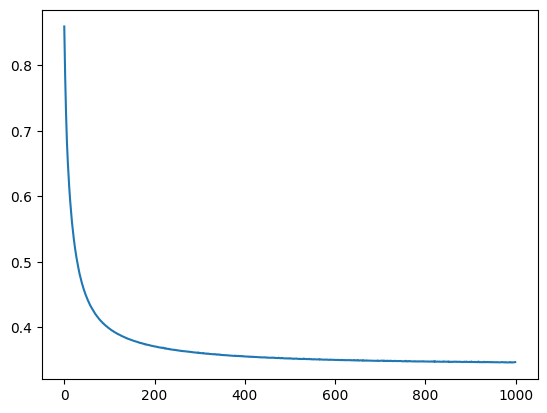

In [ ]:
plt.plot(history)

In [ ]:
for X,Y  in testloader2:
    Yhat = model2(X)
criterion(Yhat, Y)

tensor(0.5635, grad_fn=<NegBackward0>)

In [ ]:
for X,Y  in testloader3:
    Yhat = model3(X)
criterion(Yhat, Y)

tensor(0.5269, grad_fn=<NegBackward0>)

이 값이 작을수록 더 잘 적합이 된 것이므로, 이차식이 포함된 model3가 더 잘 적합되었음을 알 수 있다.